Loading and processing data...


C:\Users\ACER\AppData\Local\Temp\ipykernel_37828\137083548.py:83: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



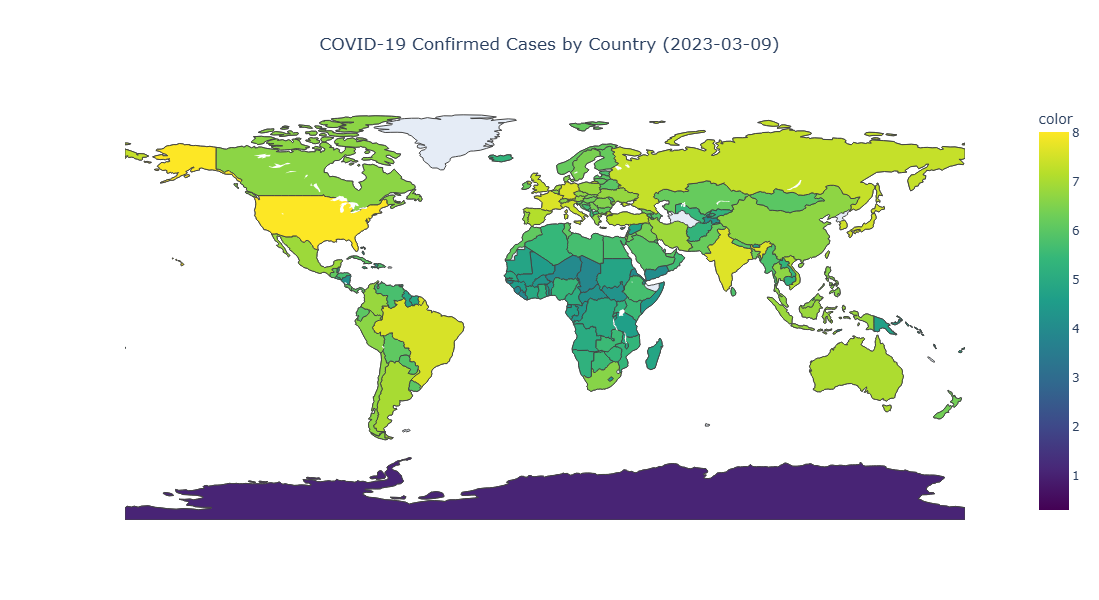

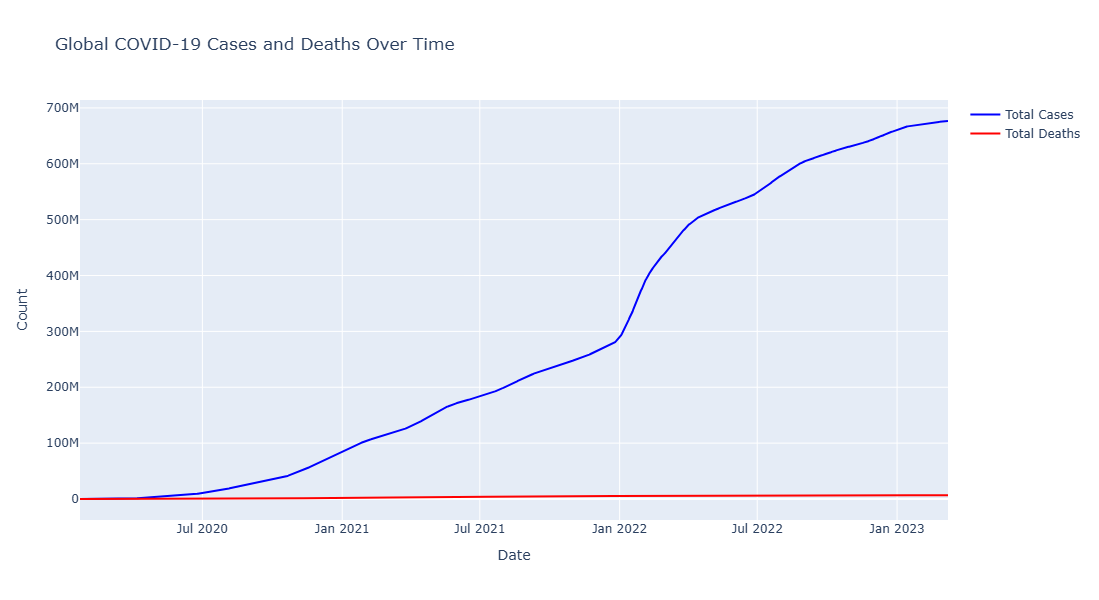


Global Summary Statistics:
Total Confirmed Cases: 676,570,149
Total Deaths: 6,881,802


In [9]:
import pandas as pd

import numpy as np

import plotly.express as px

import plotly.graph_objects as go

from datetime import datetime

import seaborn as sns

import matplotlib.pyplot as plt



# Data Processing

def load_and_process_data():

    """

    Load and process COVID-19 data from JHU CSSE GitHub repository

    """

    # Load confirmed cases data

    url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

    confirmed_df = pd.read_csv(url_confirmed)

    

    # Load deaths data

    url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

    deaths_df = pd.read_csv(url_deaths)

    

    # Melt the dataframes to convert to long format

    confirmed_melted = confirmed_df.melt(

        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],

        var_name='Date',

        value_name='Confirmed'

    )

    

    deaths_melted = deaths_df.melt(

        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],

        var_name='Date',

        value_name='Deaths'

    )

    

    # Merge confirmed cases and deaths

    covid_data = confirmed_melted.merge(

        deaths_melted[['Province/State', 'Country/Region', 'Date', 'Deaths']],

        on=['Province/State', 'Country/Region', 'Date']

    )

    

    # Convert date to datetime

    covid_data['Date'] = pd.to_datetime(covid_data['Date'])

    

    # Group by country and date

    country_data = covid_data.groupby(['Country/Region', 'Date']).agg({

        'Confirmed': 'sum',

        'Deaths': 'sum',

        'Lat': 'mean',

        'Long': 'mean'

    }).reset_index()

    

    # Calculate daily new cases and deaths

    country_data['New_Cases'] = country_data.groupby('Country/Region')['Confirmed'].diff().fillna(0)

    country_data['New_Deaths'] = country_data.groupby('Country/Region')['Deaths'].diff().fillna(0)

    

    return country_data



def create_choropleth(data, date):

    """

    Create a choropleth map for a specific date

    """

    date_data = data[data['Date'] == date]

    

    fig = px.choropleth(

        date_data,

        locations='Country/Region',

        locationmode='country names',

        color=np.log10(date_data['Confirmed'] + 1),  # Log scale for better visualization

        hover_name='Country/Region',

        hover_data=['Confirmed', 'Deaths'],

        title=f'COVID-19 Confirmed Cases by Country ({date.strftime("%Y-%m-%d")})',

        color_continuous_scale='Viridis'

    )

    

    fig.update_layout(

        title_x=0.5,

        geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),

        width=1000,

        height=600

    )

    

    return fig



def create_time_series_plots(data):

    """

    Create time series plots for global cases and deaths

    """

    global_data = data.groupby('Date').agg({

        'New_Cases': 'sum',

        'New_Deaths': 'sum',

        'Confirmed': 'sum',

        'Deaths': 'sum'

    }).reset_index()

    

    # Create figure with secondary y-axis

    fig = go.Figure()

    

    # Add traces

    fig.add_trace(

        go.Scatter(x=global_data['Date'], y=global_data['Confirmed'],

                  name="Total Cases", line=dict(color='blue'))

    )

    

    fig.add_trace(

        go.Scatter(x=global_data['Date'], y=global_data['Deaths'],

                  name="Total Deaths", line=dict(color='red'))

    )

    

    # Update layout

    fig.update_layout(

        title='Global COVID-19 Cases and Deaths Over Time',

        xaxis_title='Date',

        yaxis_title='Count',

        hovermode='x unified',

        width=1000,

        height=600

    )

    

    return fig



def main():

    # Load and process data

    print("Loading and processing data...")

    covid_data = load_and_process_data()

    

    # Create choropleth map for the most recent date

    latest_date = covid_data['Date'].max()

    choropleth_map = create_choropleth(covid_data, latest_date)

    choropleth_map.show()

    

    # Create time series plots

    time_series_plot = create_time_series_plots(covid_data)

    time_series_plot.show()

    

    # Print summary statistics

    print("\nGlobal Summary Statistics:")

    latest_global = covid_data[covid_data['Date'] == latest_date].agg({

        'Confirmed': 'sum',

        'Deaths': 'sum'

    })

    print(f"Total Confirmed Cases: {latest_global['Confirmed']:,.0f}")

    print(f"Total Deaths: {latest_global['Deaths']:,.0f}")

    

    # Export processed data

    covid_data.to_csv('processed_covid_data.csv', index=False)



if __name__ == "__main__":

    main()